# Decision Making Under Uncertainty - Assignment 2

Group 2:
- Martijn Ketelaars (ANR: 120975)
- Robbie Reyerse (ANR: 109997)
- Rosalien Timmerhuis (ANR: 520618)
- Mike Weltevrede (ANR: 756479)

## Exercise a.
Derive the product-form solution for the stationary distribution of this Jackson network and determine the stability conditions (consult Lecture on 30 October).

## Exercise b.
Write for this extended system a discrete-event simulation. In order to do this, you might need object-oriented programming.

In [1]:
import statistics
from collections import deque
from pprint import pprint

import heapq
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from scipy import stats
from tqdm import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

verbose = True

In [2]:
class Customer :

    def __init__(self, arrivalTime, priority):
        self.arrivalTime = arrivalTime
        self.serviceTime = 0
        self.systemArrivalTime = arrivalTime
        self.priority = priority
        self.NQW = 0 #NQW = needy queue waiting time
        self.needyArrivalTime = 0   #a customer arrives only one time in the system
        self.needyQueueArrivalTime = 0
        
        # location: holding, needy, content, out, queue_needy
        self.location = 'holding'
        
    def moveTo(self, location, time, newServiceTime):
        
        assert location.lower() in {'holding', 'needy', 'content', 'out', 'queue_needy'},\
            "Not a proper location. Location should be holding, needy, content, out, or queue_needy"
        
        if self.location.lower() == "holding":
            self.needyArrivalTime = time
        
        if location.lower() == "queue_needy":
            self.needyQueueArrivalTime = time
            
        self.location = location.lower()
        self.arrivalTime = time
        self.serviceTime = newServiceTime
        
    def leaveSystem(self,time):
        self.location = 'out'
        self.serviceTime = -1
        self.sojournTime = time - self.needyArrivalTime

In [3]:
class Event:

    ARRIVAL = 'ARRIVAL'
    DEPARTURE = 'DEPARTURE'
    
    def __init__(self, typ, time, cust): 
        self.type = typ
        self.time = time
        self.customer = cust
        
    def __lt__(self, other):
        return self.time < other.time

In [4]:
class FES :
    
    def __init__(self):
        self.events = []
        
    def add(self, event):
        heapq.heappush(self.events, event)
        
    def next(self):
        return heapq.heappop(self.events)

In [5]:
class NeedyServer:
    
    def __init__(self, servDist, nrServers=2):
        self.servDist = servDist
        self.nrServers = nrServers
        
        # Number of customers at this server, not including queue
        self.number_of_customers = 0
        
    def __len__(self):
        return self.number_of_customers
        
class ContentServer:
    
    def __init__(self, servDist):
        self.servDist = servDist
        self.number_of_customers = 0
    
    def __len__(self):
        return self.number_of_customers
    

In [6]:
class SimulationResults:

    def __init__(self):
        self.results = {}
        self.number_of_arrivals = {'high': 0, 'low': 0}
        self.number_of_arrivals_waiting = {'high': 0, 'low': 0}
        self.meanNQueue = 0
        
        self.total_needy_queue_length = 0
        self.sojournTimeList = []
        self.needyWaitingTimeList = []
        self.holdingTimeList = {'high_priority': [],
                                'low_priority': []}

    def registerHoldingTime(self, holdingTime, priority):
        if priority == 'high':
            self.holdingTimeList['high_priority'].append(holdingTime)
        else:
            self.holdingTimeList['low_priority'].append(holdingTime)

    def registerSojournTime(self, sojournTime):
        self.sojournTimeList.append(sojournTime)

    def registerNeedyWaitingTime(self, needyWaitingTime):
        self.needyWaitingTimeList.append(needyWaitingTime)

    def register_arrival(self, priority, waiting=False):
        self.number_of_arrivals[priority] += 1

        if waiting:
            self.number_of_arrivals_waiting[priority] += 1

    def update_total_needy_queue_length(self, length):
        self.total_needy_queue_length += length

    def getMeanSojournTime(self):
        return np.mean(self.sojournTimeList)

    def getMeanWaitingTime(self):
        return np.mean(self.needyWaitingTimeList)

    def calculate_blocking_probability(self):
        # number of arrivals that have to wait in holding / total number of arrivals

        self.results['blocking_probability'] = \
            {priority: self.number_of_arrivals_waiting[priority] / self.number_of_arrivals[priority]
             for priority in ('high', 'low')}
        self.results['blocking_probability']['total'] = \
            sum(self.number_of_arrivals_waiting.values()) / sum(self.number_of_arrivals.values())
        
    def mean_queue_length(self, t, t0, queue_needy):
        self.meanNQueue += (len(queue_needy) * (t - t0))

In [7]:
class Network:
    
    def __init__(self, lambda_L, lambda_H, servDist_needy, nrServers, servDist_content, N, p, mu=1):
        self.arrDist = stats.expon(scale=1/(lambda_L+lambda_H))
        self.high_priority_probability = lambda_H/(lambda_L+lambda_H) # probability for high
        self.N = N
        self.p = p
        self.nrServers = nrServers
        
        # Check stability
        if lambda_L + lambda_H > nrServers*mu*(1-p):
            print("WARNING: This system is not stable. Take caution c:")
        
        # Create servers
        self.NeedyServer = NeedyServer(servDist_needy, nrServers)
        self.ContentServer = ContentServer(servDist_content)
        self.simresults = SimulationResults()
        
    def simulate(self, T, burn_in_period=None):
        
        # If burn-in period is not specified, take 20% of T, rounded down
        if burn_in_period is None:
            burn_in_period = T // 5
        
        t0 = 0   # initial ti-1 for calculating mean needy queue
        t = 0 # initialise time
        total_needy_queue = 0
        
        fes = FES() 
        
        queue_holding_high = deque() # the holding queue for high priority
        queue_holding_low = deque()  # the holding queue for low priority
        queue_needy = deque()        # the queue for needy server
        res = SimulationResults()
        
        # Generate arrival of the first customer
        u = stats.uniform().rvs()
        
        if u < self.high_priority_probability:
            c0 = Customer(self.arrDist.rvs(), priority='high')
            
        else:
            c0 = Customer(self.arrDist.rvs(), priority='low')
            
        firstEvent = Event(Event.ARRIVAL, c0.arrivalTime, c0)
        fes.add(firstEvent) # schedule first arrival event
        
        while t < T:
            burn_in = (t < burn_in_period)
            
            e = fes.next()                      # jump to next event
            t = e.time                          # update the time
            c1 = e.customer                     # customer associated with this event
            
            number_in_system = len(queue_needy) + len(self.NeedyServer) + len(self.ContentServer)
            
            # Add the inner part of the sum on Week 8, Slide 15
            self.simresults.mean_queue_length(t, t0, queue_needy)
            t0 = t # Update t_i-1 to t_i
            
            # Update total number of people that had to wait in the needy queue
            if not burn_in:
                self.simresults.update_total_needy_queue_length(length=len(queue_needy))

            if e.type == 'ARRIVAL':
                
                if c1.location == 'holding':
                   
                    # Someone arrive
                    if number_in_system < self.N:
                        
                        # Admit this customer
                        if len(self.NeedyServer) < self.NeedyServer.nrServers:
                            # Admit this customer
                            serviceTime = self.NeedyServer.servDist.rvs()
                            c1.moveTo('needy', t, serviceTime)
                            
                            # Update number of customers at needy server
                            self.NeedyServer.number_of_customers += 1
                            
                            dep = Event(Event.DEPARTURE, t + serviceTime, c1)
                            fes.add(dep)

                        else:
                            # Queue in needy, independent of priority
                            queue_needy.append(c1)
                            c1.moveTo('queue_needy', t, _)

                        if not burn_in:
                            self.simresults.register_arrival(priority=c1.priority)
                            
                    else:
                        # else: add to holding queue
                        if c1.priority == 'high':
                            queue_holding_high.append(c1)
                        else:
                            queue_holding_low.append(c1)
                            
                        if not burn_in:
                            self.simresults.register_arrival(priority=c1.priority, waiting=True)

                    # Schedule new arrival
                    u = stats.uniform().rvs()

                    if u < self.high_priority_probability:
                        c2 = Customer(t + self.arrDist.rvs(), priority='high')
                    else:
                        c2 = Customer(t + self.arrDist.rvs(), priority='low')

                    arrival = Event(Event.ARRIVAL, c2.arrivalTime, c2)
                    fes.add(arrival)
                else:
                    raise Exception("ERROR: Arrival from", c1.location)
                
            elif e.type == 'DEPARTURE':
                # Then it's a departure
                # Check if departed from needy or from content
                if c1.location == 'content':
                    
                    # Update number of customers at needy server
                    self.ContentServer.number_of_customers -= 1
                    
                    if len(self.NeedyServer) < self.NeedyServer.nrServers:
                        serviceTime = self.NeedyServer.servDist.rvs()
                        c1.moveTo('needy', t, serviceTime)
                        
                        # Update number of customers at needy server
                        self.NeedyServer.number_of_customers += 1
                        
                        dep = Event(Event.DEPARTURE, t + serviceTime, c1)
                        fes.add(dep)
                    else:
                        queue_needy.append(c1)
                        c1.moveTo('queue_needy', t, _)
                        
                elif c1.location == 'needy':
                    # Update number of customers at needy server - someone leaves
                    self.NeedyServer.number_of_customers -= 1
                    
                    # Admit person from needy queue, if nonempty
                    if len(queue_needy) > 0:
                        c2 = queue_needy.popleft()
                        
                        if not burn_in:
                            self.simresults.registerNeedyWaitingTime(t - c2.needyQueueArrivalTime)
                        
                        serviceTime = self.NeedyServer.servDist.rvs()
                        c2.moveTo('needy', t, serviceTime)

                        # Update number of customers at needy server
                        self.NeedyServer.number_of_customers += 1

                        dep = Event(Event.DEPARTURE, t + serviceTime, c2)
                        fes.add(dep)
                    
                    # Check if leaves or goes to content
                    u = stats.uniform().rvs()

                    if u < self.p:
                        # Go to content
                        serviceTime = self.ContentServer.servDist.rvs()
                        c1.moveTo('content', t, serviceTime)
                        
                        # Update number of customers at needy server
                        self.ContentServer.number_of_customers += 1
                        
                        dep = Event(Event.DEPARTURE, t + serviceTime, c1)
                        fes.add(dep)
                        
                    else:
                        # Leave system
                        # Set c1.location to 'out', c1.serviceTime to -1, and calculate sojourn time
                        c1.leaveSystem(t) 
                        
                        if not burn_in:
                            self.simresults.registerSojournTime(c1.sojournTime)
                        
                        # Admit someone from holding queue
                        if len(queue_holding_high) > 0:
                            c2 = queue_holding_high.popleft()
                            
                            # Note that we only enter here if a person is admitted from the holding queue
                            if len(self.NeedyServer) < self.NeedyServer.nrServers:
                                serviceTime = self.NeedyServer.servDist.rvs()
                                c2.moveTo('needy', t, serviceTime)

                                # Update number of customers at needy server
                                self.NeedyServer.number_of_customers += 1

                                dep = Event(Event.DEPARTURE, t + serviceTime, c2)
                                fes.add(dep)
                            else:
                                queue_needy.append(c2)
                                c2.moveTo('queue_needy', t, _)
                                
                            if not burn_in:
                                self.simresults.registerHoldingTime(c2.needyArrivalTime - c2.systemArrivalTime,
                                                                    c2.priority)
                            
                        elif len(queue_holding_low) > 0:
                            c2 = queue_holding_low.popleft()
                            
                            # Note that we only enter here if a person is admitted from the holding queue
                            if len(self.NeedyServer) < self.NeedyServer.nrServers:
                                serviceTime = self.NeedyServer.servDist.rvs()
                                c2.moveTo('needy', t, serviceTime)

                                # Update number of customers at needy server
                                self.NeedyServer.number_of_customers += 1

                                dep = Event(Event.DEPARTURE, t + serviceTime, c2)
                                fes.add(dep)
                            else:
                                queue_needy.append(c2)
                                c2.moveTo('queue_needy', t, _)
                                
                            if not burn_in:
                                self.simresults.registerHoldingTime(c2.needyArrivalTime - c2.systemArrivalTime,
                                                                    c2.priority)
                        else:
                            pass
                        
                        
                else:
                    raise Exception("ERROR: Departure from", c1.location)
                    
        self.largest_T = t
        return None

In [60]:
np.random.seed(1)
T = 10000

# Initialise arguments
lambda_L = 0.5
lambda_H = 0.25
nrServers = 2
N = 5
p = 0.4

mu = 1
delta = 1

servDist_needy = stats.expon(scale=float(1/mu))
servDist_content = stats.expon(scale=float(1/delta))

In [61]:
sim = Network(lambda_L, lambda_H, servDist_needy, nrServers,
              servDist_content, N, p)

sim.simulate(T, 1000)

In [10]:
sim.simresults.calculate_blocking_probability()
print(f"Blocking Probability: {sim.simresults.results['blocking_probability']} \n")

print(f"Mean Needy Queue Length: {sim.simresults.meanNQueue/sim.largest_T}")
print(f"Mean Needy Queue Waiting Time: {sim.simresults.getMeanWaitingTime()} \n")

for ht in sim.simresults.holdingTimeList.values():
    print(f"{len(ht)} high priority customers had to wait in the holding queue "
          f"for a mean time of {np.mean(ht)}")
    
print(f"\nMean Sojourn Time: {sim.simresults.getMeanSojournTime()}")

Blocking Probability: {'high': 0.1537091988130564, 'low': 0.14842072983747318, 'total': 0.1502224019409624} 

Mean Needy Queue Length: 0.5269156751622386
Mean Needy Queue Waiting Time: 0.9246955367067142 

259 high priority customers had to wait in the holding queue for a mean time of 1.1047366343957141
484 high priority customers had to wait in the holding queue for a mean time of 2.9566552206618963

Mean Sojourn Time: 3.03309618597503


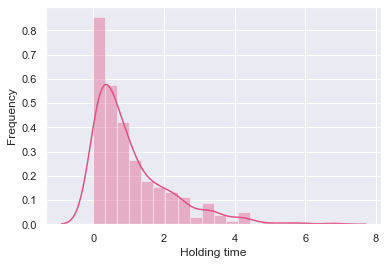

In [29]:
sns.distplot(sim.simresults.holdingTimeList['high_priority'], color='#de5285')
#plt.title("Distribution of the holding times for high priority customers")
plt.xlabel("Holding time")
plt.ylabel("Frequency")
plt.show()

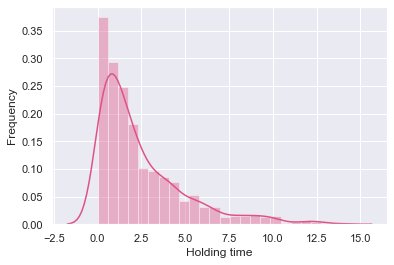

In [30]:
sns.distplot(sim.simresults.holdingTimeList['low_priority'], color='#de5285')
#plt.title("Distribution of the holding times for low priority customers")
plt.xlabel("Holding time")
plt.ylabel("Frequency")
plt.show()

## Exercise c.
Use your discrete-event simulation to present performance measures (perhaps probability of blocking for the different customer priority classes, probability of waiting, mean queue length, mean waiting time,...) for the extended system for different values of $\lambda_L$, $\lambda_H$, and $\delta$, and different values of $N$. Elaborate on your findings by creating a comprehensive management report including several sensitivity analyses.

In [38]:
#changing lambda L (and thus fix lambda H)
np.random.seed(1)
runs = 30
T = 10000

# Specify which values for lambda_L to test
lambda_H_temp = 1/100
lambda_L_array = np.linspace(lambda_H_temp, (1-p)*nrServers*mu-lambda_H_temp, runs)
lambda_L_temp = lambda_L

probabilities_total = np.zeros(runs)
probabilities_high = np.zeros(runs)
probabilities_low = np.zeros(runs)

for i in range(runs):
    lambda_L = lambda_L_array[i]
    sim = Network(lambda_L, lambda_H_temp, servDist_needy, nrServers,
                  servDist_content, N, p)
    sim.simulate(T)
    sim.simresults.calculate_blocking_probability()
    
    if verbose:
        # verbose is specified as a Boolean at the top of this file. If True, print this, else do not.
        print("Probability for lambda_L equal to", lambda_L)
        print("Blocking probability:", sim.simresults.results['blocking_probability'])
        print("")
    
    probabilities_total[i] = sim.simresults.results['blocking_probability']['total']
    probabilities_high[i] = sim.simresults.results['blocking_probability']['high']
    probabilities_low[i] = sim.simresults.results['blocking_probability']['low']
    
# Reset lambda_L
lambda_L = lambda_L_temp

Probability for lambda_L equal to 0.01
Blocking probability: {'high': 0.0, 'low': 0.0, 'total': 0.0}

Probability for lambda_L equal to 0.05068965517241379
Blocking probability: {'high': 0.0, 'low': 0.0, 'total': 0.0}

Probability for lambda_L equal to 0.09137931034482757
Blocking probability: {'high': 0.0, 'low': 0.0, 'total': 0.0}

Probability for lambda_L equal to 0.13206896551724137
Blocking probability: {'high': 0.0, 'low': 0.0, 'total': 0.0}

Probability for lambda_L equal to 0.17275862068965517
Blocking probability: {'high': 0.0, 'low': 0.0, 'total': 0.0}

Probability for lambda_L equal to 0.21344827586206896
Blocking probability: {'high': 0.0, 'low': 0.0011587485515643105, 'total': 0.0011098779134295228}

Probability for lambda_L equal to 0.25413793103448273
Blocking probability: {'high': 0.0, 'low': 0.00387409200968523, 'total': 0.0037088548910523874}

Probability for lambda_L equal to 0.29482758620689653
Blocking probability: {'high': 0.0, 'low': 0.004154549231408392, 'total'

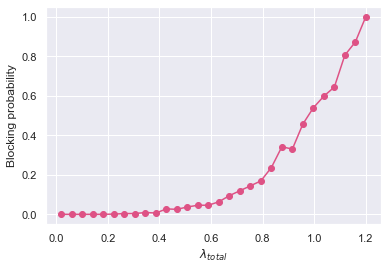

In [39]:
plt.plot(lambda_L_array+lambda_H_temp, probabilities_total, marker='o', color='#de5285', label="Total")

plt.xlabel('$\lambda_{total}$')
plt.ylabel('Blocking probability')
#plt.title('Change in total blocking probability as $\lambda_{total}$ changes')
plt.show()

In [65]:
#changing lambda H (and thus fix lambda_L)
np.random.seed(1)

# Specify which values for lambda_H to test
lambda_L_temp = 1/100
lambda_H_array = np.linspace(lambda_L_temp, (1-p)*nrServers*mu-lambda_L_temp, runs)
lambda_H_temp = lambda_H

probabilities_total = np.zeros(runs)
probabilities_high = np.zeros(runs)
probabilities_low = np.zeros(runs)

for i in range(runs):
    lambda_H = lambda_H_array[i]
    sim = Network(lambda_L_temp, lambda_H, servDist_needy, nrServers,
                  servDist_content, N, p)
    sim.simulate(T, 100)
    
    print(sim.simresults.number_of_arrivals)
    
    sim.simresults.calculate_blocking_probability()
    
    if verbose:
        # verbose is specified as a Boolean at the top of this file. If True, print this, else do not.
        print("Probability for lambda_H equal to", lambda_H)
        print("Blocking probability:", sim.simresults.results['blocking_probability'])
        print("")
    
    probabilities_total[i] = sim.simresults.results['blocking_probability']['total']
    probabilities_high[i] = sim.simresults.results['blocking_probability']['high']
    probabilities_low[i] = sim.simresults.results['blocking_probability']['low']
    
lambda_H = lambda_H_temp

{'high': 110, 'low': 114}
Probability for lambda_H equal to 0.01
Blocking probability: {'high': 0.0, 'low': 0.0, 'total': 0.0}

{'high': 537, 'low': 102}
Probability for lambda_H equal to 0.05068965517241379
Blocking probability: {'high': 0.0, 'low': 0.0, 'total': 0.0}

{'high': 955, 'low': 103}
Probability for lambda_H equal to 0.09137931034482757
Blocking probability: {'high': 0.0, 'low': 0.0, 'total': 0.0}

{'high': 1270, 'low': 104}
Probability for lambda_H equal to 0.13206896551724137
Blocking probability: {'high': 0.0, 'low': 0.0, 'total': 0.0}

{'high': 1732, 'low': 95}
Probability for lambda_H equal to 0.17275862068965517
Blocking probability: {'high': 0.0005773672055427252, 'low': 0.0, 'total': 0.0005473453749315818}

{'high': 2167, 'low': 120}
Probability for lambda_H equal to 0.21344827586206896
Blocking probability: {'high': 0.0023073373327180432, 'low': 0.0, 'total': 0.0021862702229995625}

{'high': 2537, 'low': 99}
Probability for lambda_H equal to 0.25413793103448273
Blo

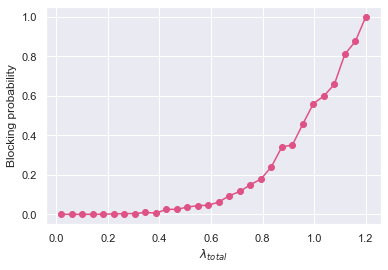

In [67]:
plt.plot(lambda_H_array+lambda_L_temp, probabilities_total, marker='o', color='#de5285', label="Total")

plt.xlabel('$\lambda_{total}$')
plt.ylabel('Blocking probability')
#plt.title('Change in total blocking probability as $\lambda_H$ changes')
plt.show()

In [62]:
#changing lambda H (and thus fix lambda_L)
np.random.seed(1)

# Specify which values for lambda_H to test
smooth_range = 5

delta_temp = delta
delta_array = np.linspace(1, 4*nrServers*mu, runs)

probabilities_total = np.zeros(runs)
probabilities_high = np.zeros(runs)
probabilities_low = np.zeros(runs)

probs = {key: [] for key in delta_array}

for j in range(smooth_range):
    for i in range(runs):
        delta = delta_array[i]
        servDist_content = stats.expon(scale=float(1/delta))

        sim = Network(lambda_L, lambda_H, servDist_needy, nrServers,
                      servDist_content, N, p)
        sim.simulate(T, 100)
        sim.simresults.calculate_blocking_probability()

        if verbose:
            # verbose is specified as a Boolean at the top of this file. If True, print this, else do not.
            print("Probability for delta equal to", delta)
            print("Blocking probability:", sim.simresults.results['blocking_probability'])
            print("")

        probabilities_total[i] = sim.simresults.results['blocking_probability']['total']
        probabilities_high[i] = sim.simresults.results['blocking_probability']['high']
        probabilities_low[i] = sim.simresults.results['blocking_probability']['low']
    
        probs[delta].append(sim.simresults.results['blocking_probability']['total'])
    
# Reset to original values
delta = delta_temp
servDist_content = stats.expon(scale=float(1/delta))

Probability for delta equal to 1.0
Blocking probability: {'high': 0.14219653179190753, 'low': 0.13955391855944344, 'total': 0.140470462443197}

Probability for delta equal to 1.2413793103448276
Blocking probability: {'high': 0.16507177033492823, 'low': 0.16534653465346535, 'total': 0.16525535856046572}

Probability for delta equal to 1.4827586206896552
Blocking probability: {'high': 0.13709032773780974, 'low': 0.14409687184661957, 'total': 0.14174601045997048}

Probability for delta equal to 1.7241379310344827
Blocking probability: {'high': 0.13324873096446702, 'low': 0.13950667205822886, 'total': 0.1374829001367989}

Probability for delta equal to 1.9655172413793105
Blocking probability: {'high': 0.16713539574126154, 'low': 0.16050354051927615, 'total': 0.1626832166908755}

Probability for delta equal to 2.206896551724138
Blocking probability: {'high': 0.13749506124061636, 'low': 0.14355727996732692, 'total': 0.14149165320409263}

Probability for delta equal to 2.4482758620689653
Bloc

Probability for delta equal to 6.310344827586207
Blocking probability: {'high': 0.08880778588807786, 'low': 0.10501438553226469, 'total': 0.09956355701036552}

Probability for delta equal to 6.551724137931035
Blocking probability: {'high': 0.16504065040650406, 'low': 0.14860744053669445, 'total': 0.15408591950128744}

Probability for delta equal to 6.793103448275862
Blocking probability: {'high': 0.118, 'low': 0.11692739671079021, 'total': 0.1172855997862677}

Probability for delta equal to 7.0344827586206895
Blocking probability: {'high': 0.11365461847389559, 'low': 0.11260268483269886, 'total': 0.1129528137949472}

Probability for delta equal to 7.275862068965518
Blocking probability: {'high': 0.1254180602006689, 'low': 0.12135238478567116, 'total': 0.12267354978943078}

Probability for delta equal to 7.517241379310345
Blocking probability: {'high': 0.15011914217633043, 'low': 0.13950276243093923, 'total': 0.14302662799894542}

Probability for delta equal to 7.758620689655173
Blockin

Probability for delta equal to 4.379310344827586
Blocking probability: {'high': 0.11986727498963086, 'low': 0.10543324580892749, 'total': 0.11016028253192067}

Probability for delta equal to 4.620689655172415
Blocking probability: {'high': 0.11370967741935484, 'low': 0.11995884773662552, 'total': 0.1178474114441417}

Probability for delta equal to 4.862068965517242
Blocking probability: {'high': 0.13501602564102563, 'low': 0.12422360248447205, 'total': 0.12782155736610123}

Probability for delta equal to 5.103448275862069
Blocking probability: {'high': 0.11004016064257029, 'low': 0.11790744466800805, 'total': 0.11528150134048257}

Probability for delta equal to 5.344827586206897
Blocking probability: {'high': 0.12197125256673512, 'low': 0.11627906976744186, 'total': 0.11813554781676935}

Probability for delta equal to 5.586206896551724
Blocking probability: {'high': 0.12570507655116842, 'low': 0.12148208139299453, 'total': 0.12289448861339441}

Probability for delta equal to 5.82758620

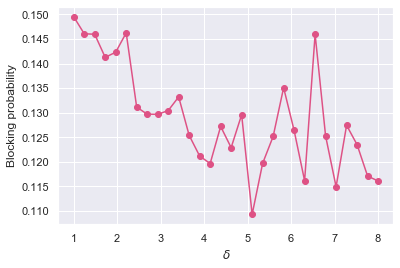

In [63]:
plt.plot(delta_array, list([np.mean(probs[x]) for x in probs]), marker='o', color='#de5285', label="Total")

plt.xlabel('$\delta$')
plt.ylabel('Blocking probability')
#plt.title('Change in total blocking probability as $\delta$ changes (smoothed)')
plt.show()

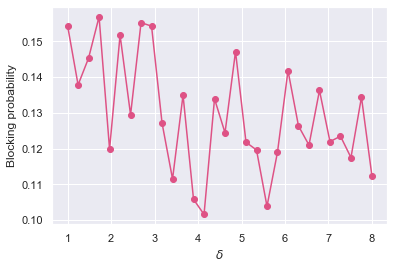

In [64]:
plt.plot(delta_array, probabilities_total, marker='o', color='#de5285', label="Total")

plt.xlabel('$\delta$')
plt.ylabel('Blocking probability')
#plt.title('Change in total blocking probability as $\delta$ changes')
plt.show()

In [44]:
# Changing p (comparing the needy queue length)
np.random.seed(1)

p_temp = p
p_array = np.linspace(0.01, 0.99, runs)
mean_queue_length = np.zeros(runs)

for i in range(runs):
    p = p_array[i]
    sim = Network(lambda_L, lambda_H, servDist_needy, nrServers,
                  servDist_content, N, p)
    sim.simulate(T)
    
    mean_needy = sim.simresults.meanNQueue/sim.largest_T
    
    if verbose:
        print("Probability of not leaving system equal to", p)
        print("Mean queue length: ", mean_needy)
        print("")
    
    mean_queue_length[i] = mean_needy
    
p = p_temp

Probability of not leaving system equal to 0.01
Mean queue length:  0.10714289339596021

Probability of not leaving system equal to 0.04379310344827586
Mean queue length:  0.14225447214391476

Probability of not leaving system equal to 0.07758620689655171
Mean queue length:  0.15869890751503615

Probability of not leaving system equal to 0.11137931034482758
Mean queue length:  0.17082191963583485

Probability of not leaving system equal to 0.14517241379310344
Mean queue length:  0.19646672496670678

Probability of not leaving system equal to 0.1789655172413793
Mean queue length:  0.22366925460159262

Probability of not leaving system equal to 0.21275862068965518
Mean queue length:  0.23428257103875957

Probability of not leaving system equal to 0.24655172413793103
Mean queue length:  0.24930082952582472

Probability of not leaving system equal to 0.2803448275862069
Mean queue length:  0.3399812611851105

Probability of not leaving system equal to 0.31413793103448273
Mean queue length: 

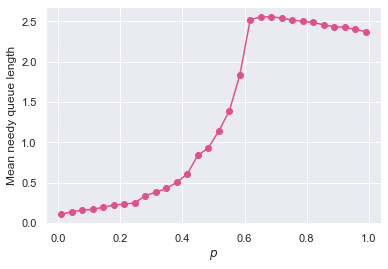

In [45]:
plt.plot(p_array, mean_queue_length, marker='o', color='#de5285')
plt.xlabel('$p$')
plt.ylabel('Mean needy queue length')
#plt.title('Mean needy queue length as remaining probability $p$ changes')
plt.show()

In [56]:
# Changing N (comparing the needy queue length)
np.random.seed(1)

N_temp = N

# Specify which values for N to test
N_array = np.linspace(5, 1000, runs)
mean_queue_length = np.zeros(runs)

for i in range(runs):
    N = N_array[i]
    sim = Network(lambda_L, lambda_H, servDist_needy, nrServers,
                  servDist_content, N, p)  #change lambda here
    sim.simulate(T)
        
    mean_needy = sim.simresults.meanNQueue/sim.largest_T

    if verbose:
        # verbose is specified as a Boolean at the top of this file. If True, print this, else do not.
        print(f"N={N} - Mean queue length = {mean_needy}")
        print("")
    
    mean_queue_length[i] = mean_needy

N = N_temp

N=5.0 - Mean queue length = 0.6186787761856065



KeyboardInterrupt: 

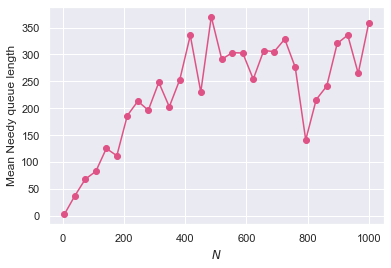

In [50]:
plt.plot(N_array, mean_queue_length, marker='o', color='#de5285')
plt.xlabel('$N$')
plt.ylabel('Mean Needy queue length')
#plt.title('Mean Needy queue length as maximum number of customers $N$ changes')
plt.show()

In [70]:
# Changing N (comparing the mean sojourn time)
np.random.seed(1)

N_temp = N

# Specify which values for N to test
N_array = np.linspace(5, 1000, runs)
mean_sojourn_length = np.zeros(runs)

for i in range(runs):
    N = N_array[i]
    sim = Network(lambda_L, lambda_H, servDist_needy, nrServers,
                  servDist_content, N, p)  
    sim.simulate(T)
        
    mean_sojourn = np.mean(sim.simresults.sojournTimeList)

    if verbose:
        # verbose is specified as a Boolean at the top of this file. If True, print this, else do not.
        print(f"N={N} - Mean sojourn time = {mean_sojourn}")
        print("")
    
    mean_sojourn_length[i] = mean_sojourn

N = N_temp

N=5.0 - Mean sojourn time = 3.079234684718333

N=39.310344827586206 - Mean sojourn time = 3.4278506427196365

N=73.62068965517241 - Mean sojourn time = 3.2105627182135397

N=107.93103448275862 - Mean sojourn time = 3.339832204071789

N=142.24137931034483 - Mean sojourn time = 3.5248189357442756

N=176.55172413793105 - Mean sojourn time = 3.3408599201984766

N=210.86206896551724 - Mean sojourn time = 3.6578131068139195

N=245.17241379310343 - Mean sojourn time = 3.2449873996094527

N=279.48275862068965 - Mean sojourn time = 3.2274671303597904

N=313.7931034482759 - Mean sojourn time = 3.2734275062222977

N=348.1034482758621 - Mean sojourn time = 3.3808433938494464

N=382.41379310344826 - Mean sojourn time = 3.333977712199592

N=416.7241379310345 - Mean sojourn time = 3.400432493277977

N=451.0344827586207 - Mean sojourn time = 3.330842064899007

N=485.34482758620686 - Mean sojourn time = 3.66720933979224

N=519.6551724137931 - Mean sojourn time = 3.3701367213575404

N=553.9655172413793 

In [77]:
# Changing p (comparing the mean sojourn time)
np.random.seed(1)

p_temp = p

# Specify which values for N to test
p_array = np.linspace(0.01, 0.8, runs)
mean_sojourn_length = np.zeros(runs)

for i in range(runs):
    p = p_array[i]
    sim = Network(lambda_L, lambda_H, servDist_needy, nrServers,
                  servDist_content, N, p)  
    sim.simulate(T)
        
    mean_sojourn = np.mean(sim.simresults.sojournTimeList)

    if verbose:
        # verbose is specified as a Boolean at the top of this file. If True, print this, else do not.
        print(f"p={p} - Mean sojourn time = {mean_sojourn}")
        print("")
    
    mean_sojourn_length[i] = mean_sojourn

p = p_temp

p=0.01 - Mean sojourn time = 1.156717913039782

p=0.03724137931034483 - Mean sojourn time = 1.2776773263631467

p=0.06448275862068965 - Mean sojourn time = 1.362374430977535

p=0.09172413793103448 - Mean sojourn time = 1.444419502740542

p=0.11896551724137931 - Mean sojourn time = 1.4699451230347838

p=0.14620689655172414 - Mean sojourn time = 1.5483620292338165

p=0.17344827586206898 - Mean sojourn time = 1.679285191737975

p=0.20068965517241383 - Mean sojourn time = 1.8092515328093468

p=0.22793103448275864 - Mean sojourn time = 1.9961628245256606

p=0.25517241379310346 - Mean sojourn time = 2.0653301319628365

p=0.2824137931034483 - Mean sojourn time = 2.2258498972638905

p=0.30965517241379314 - Mean sojourn time = 2.3676469419550825

p=0.33689655172413796 - Mean sojourn time = 2.6070597586528907

p=0.3641379310344828 - Mean sojourn time = 2.6299206745101102

p=0.39137931034482765 - Mean sojourn time = 2.9404662583701318

p=0.41862068965517246 - Mean sojourn time = 3.120894503175226

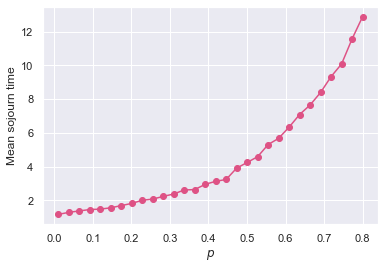

In [78]:
plt.plot(p_array, mean_sojourn_length, marker='o', color='#de5285')
plt.xlabel('$p$')
plt.ylabel('Mean sojourn time')
#plt.title('Mean needy queue length as remaining probability $p$ changes')
plt.show()

## Exercise d.
Investigate the difference in performance between the original system ($N = 1$) and the extended system (finite $N$). For instance, how fast does the behavior of the extended system mimic the original system behavior as $N$ increases?